# Homework 1: How much data do you need? Using CIFAR-100
Advanced AI Methods \\
Dr. Kerby

## Question 1: Create a CNN to classify CIFAR-100
Use the [CIFAR-100](https://www.tensorflow.org/datasets/catalog/cifar100) dataset. This [link](https://www.cs.toronto.edu/~kriz/cifar.html) also has some useful information.

You can utilize `keras.datasets.cifar100.load_data()` to import the dataset as `numpy ndarrays` or `tfds.load('cifar100')` to import the dataset as `tf.data.Dataset`.

You must utilize transfer learning. You are welcome to choose any of the expert CNN models available in [Keras Applications](https://keras.io/api/applications/). I think EfficientNetV2 is probably the best, but it would be fun to see if the results hold for other expert CNNs, so feel free to try a different one and we'll compare.

Your image classifier should output both labels (the coarse and fine labels). First create a classifier for all 100 classes and utilizing all available training data (500 images per class). Report your accuracy for both training and testing, for both the coarse and fine labels. This accuracy will serve as a baseline accuracy for later on. Plot several misclassified images. Plot a confusion matrix for the coarse labels.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.applications import EfficientNetB3
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.metrics import accuracy_score
import numpy as np

Epoch 1/10
782/782 [==============================] - ETA: 0s - loss: 4.6077 - accuracy: 0.0095
Epoch 1: val_loss improved from inf to 4.60519, saving model to model.h5
782/782 [==============================] - 22s 16ms/step - loss: 4.6077 - accuracy: 0.0095 - val_loss: 4.6052 - val_accuracy: 0.0100
Epoch 2/10
780/782 [============================>.] - ETA: 0s - loss: 4.6058 - accuracy: 0.0084
Epoch 2: val_loss improved from 4.60519 to 4.60518, saving model to model.h5
782/782 [==============================] - 11s 13ms/step - loss: 4.6058 - accuracy: 0.0084 - val_loss: 4.6052 - val_accuracy: 0.0100
Epoch 3/10
778/782 [============================>.] - ETA: 0s - loss: 4.6057 - accuracy: 0.0085
Epoch 3: val_loss did not improve from 4.60518
782/782 [==============================] - 9s 12ms/step - loss: 4.6057 - accuracy: 0.0085 - val_loss: 4.6052 - val_accuracy: 0.0100
Epoch 4/10
779/782 [============================>.] - ETA: 0s - loss: 4.6057 - accuracy: 0.0086
Epoch 4: val_loss did

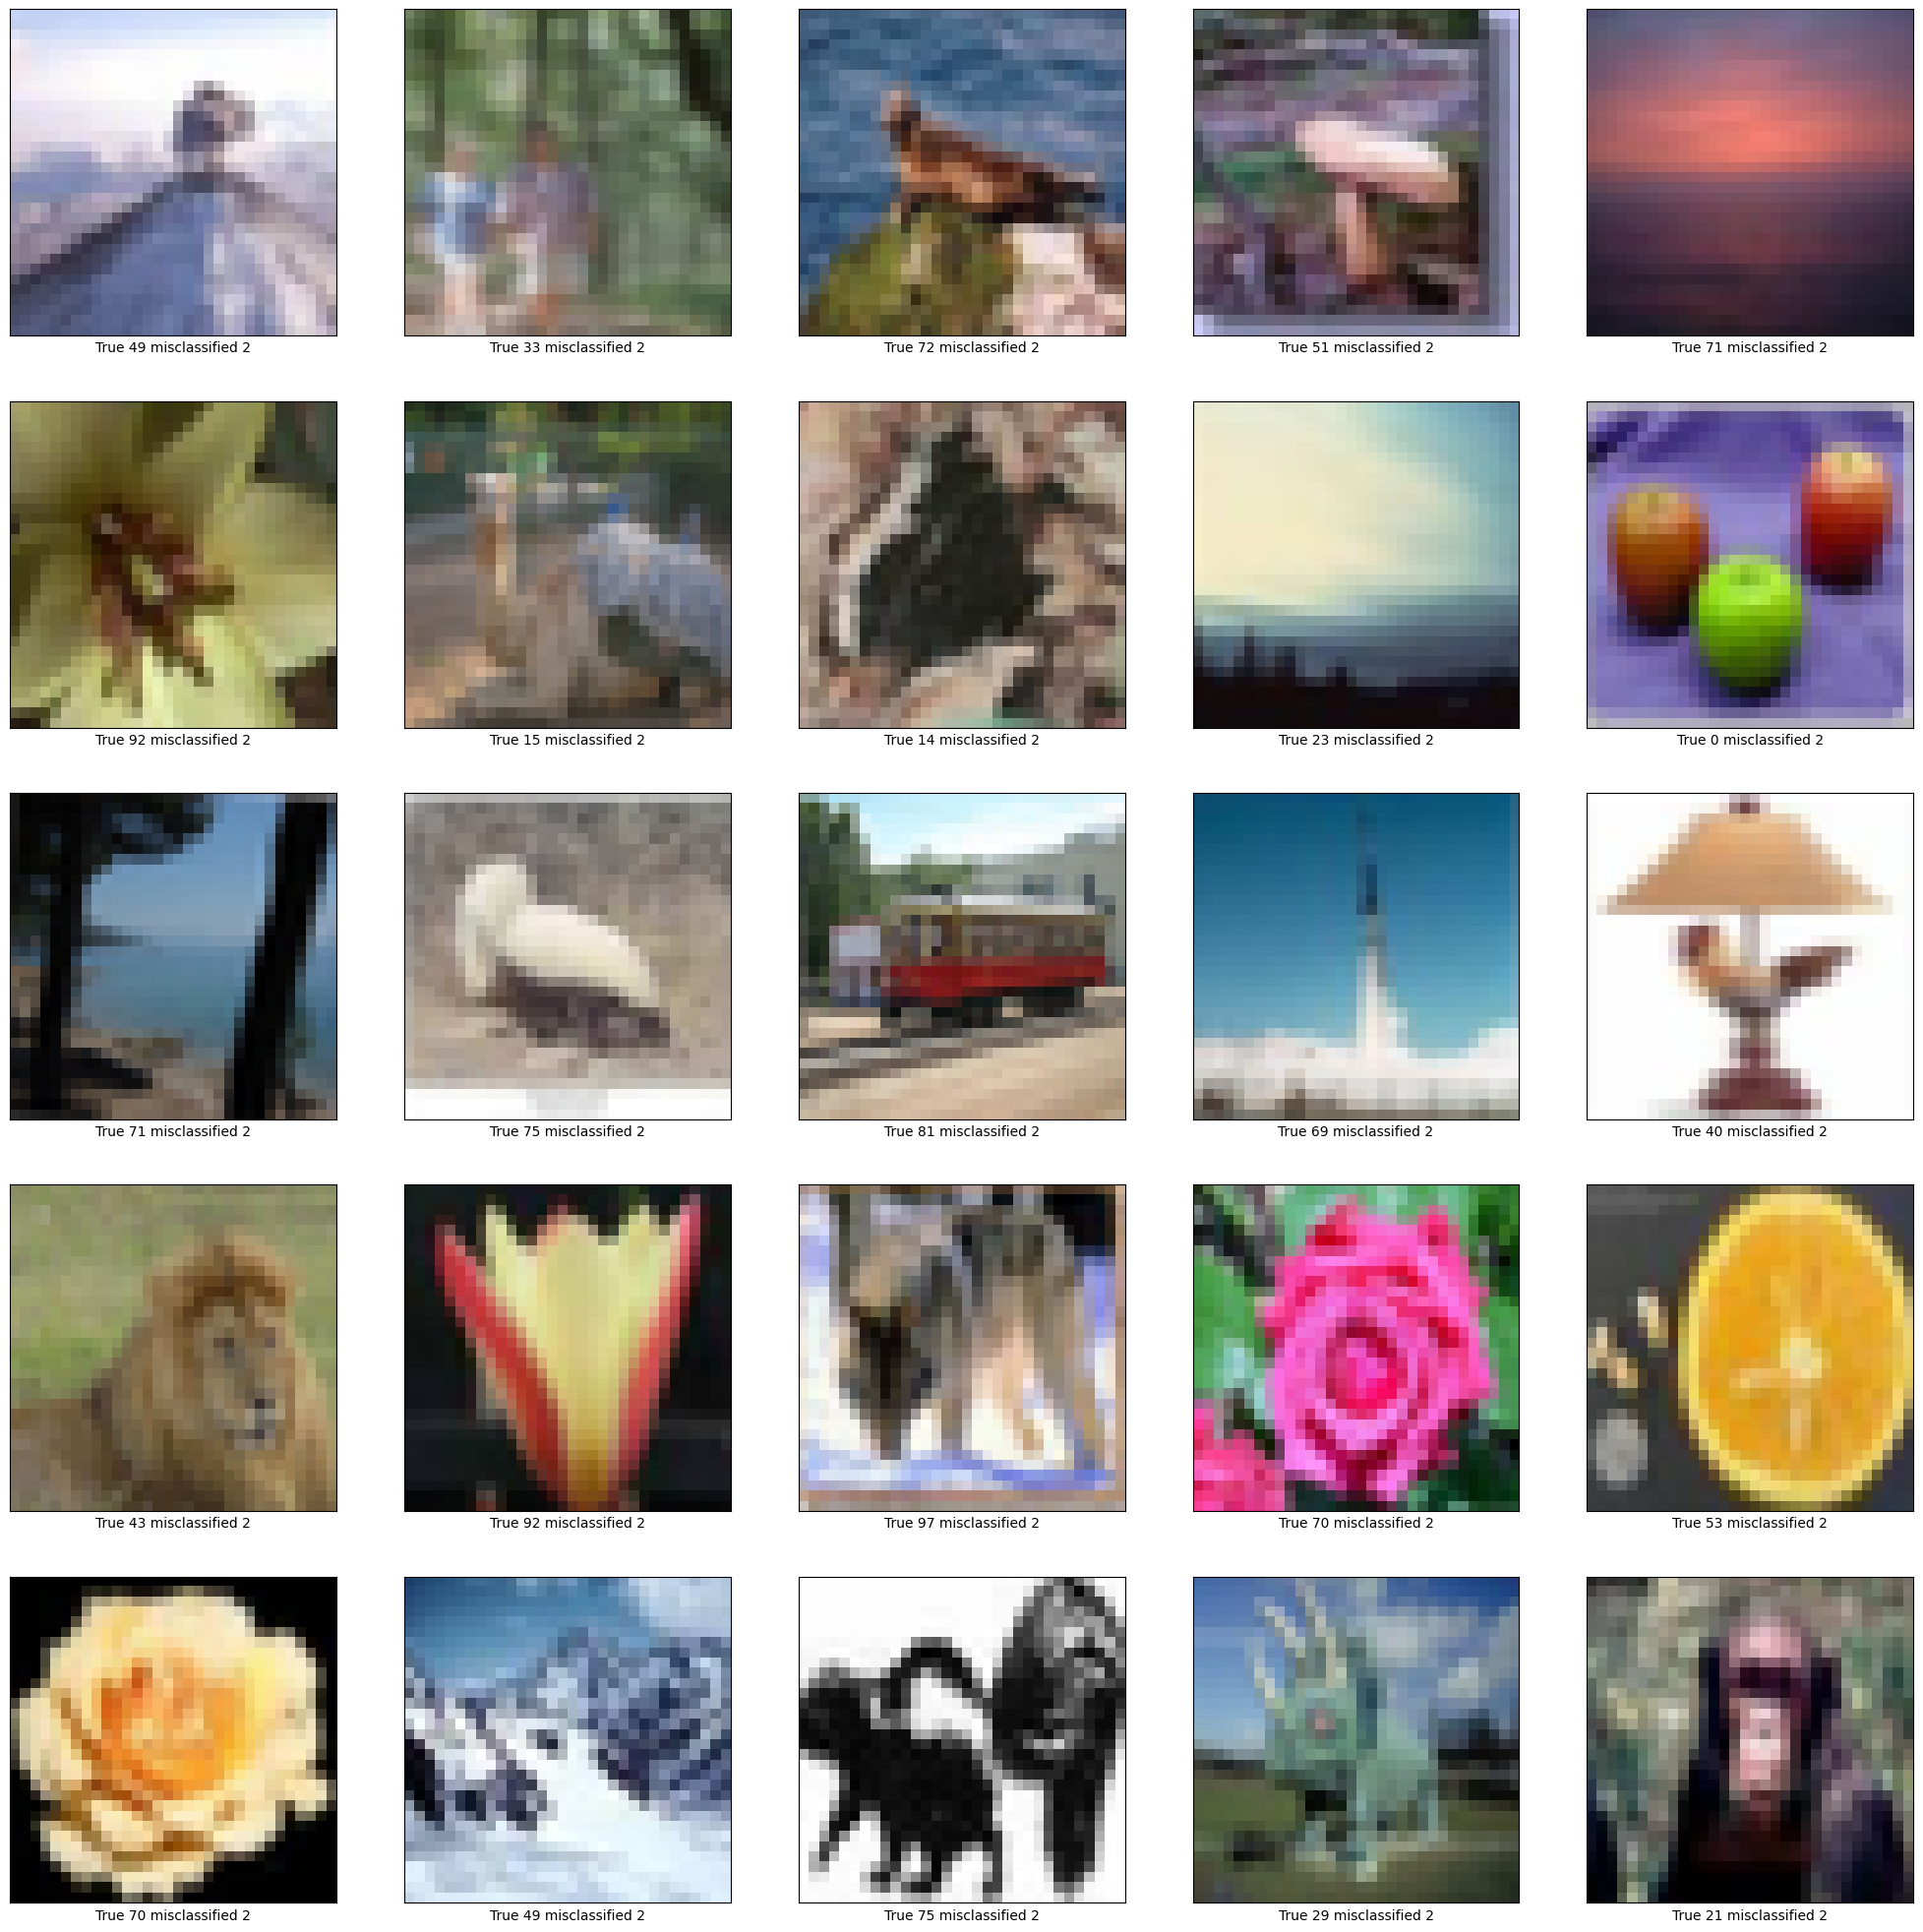

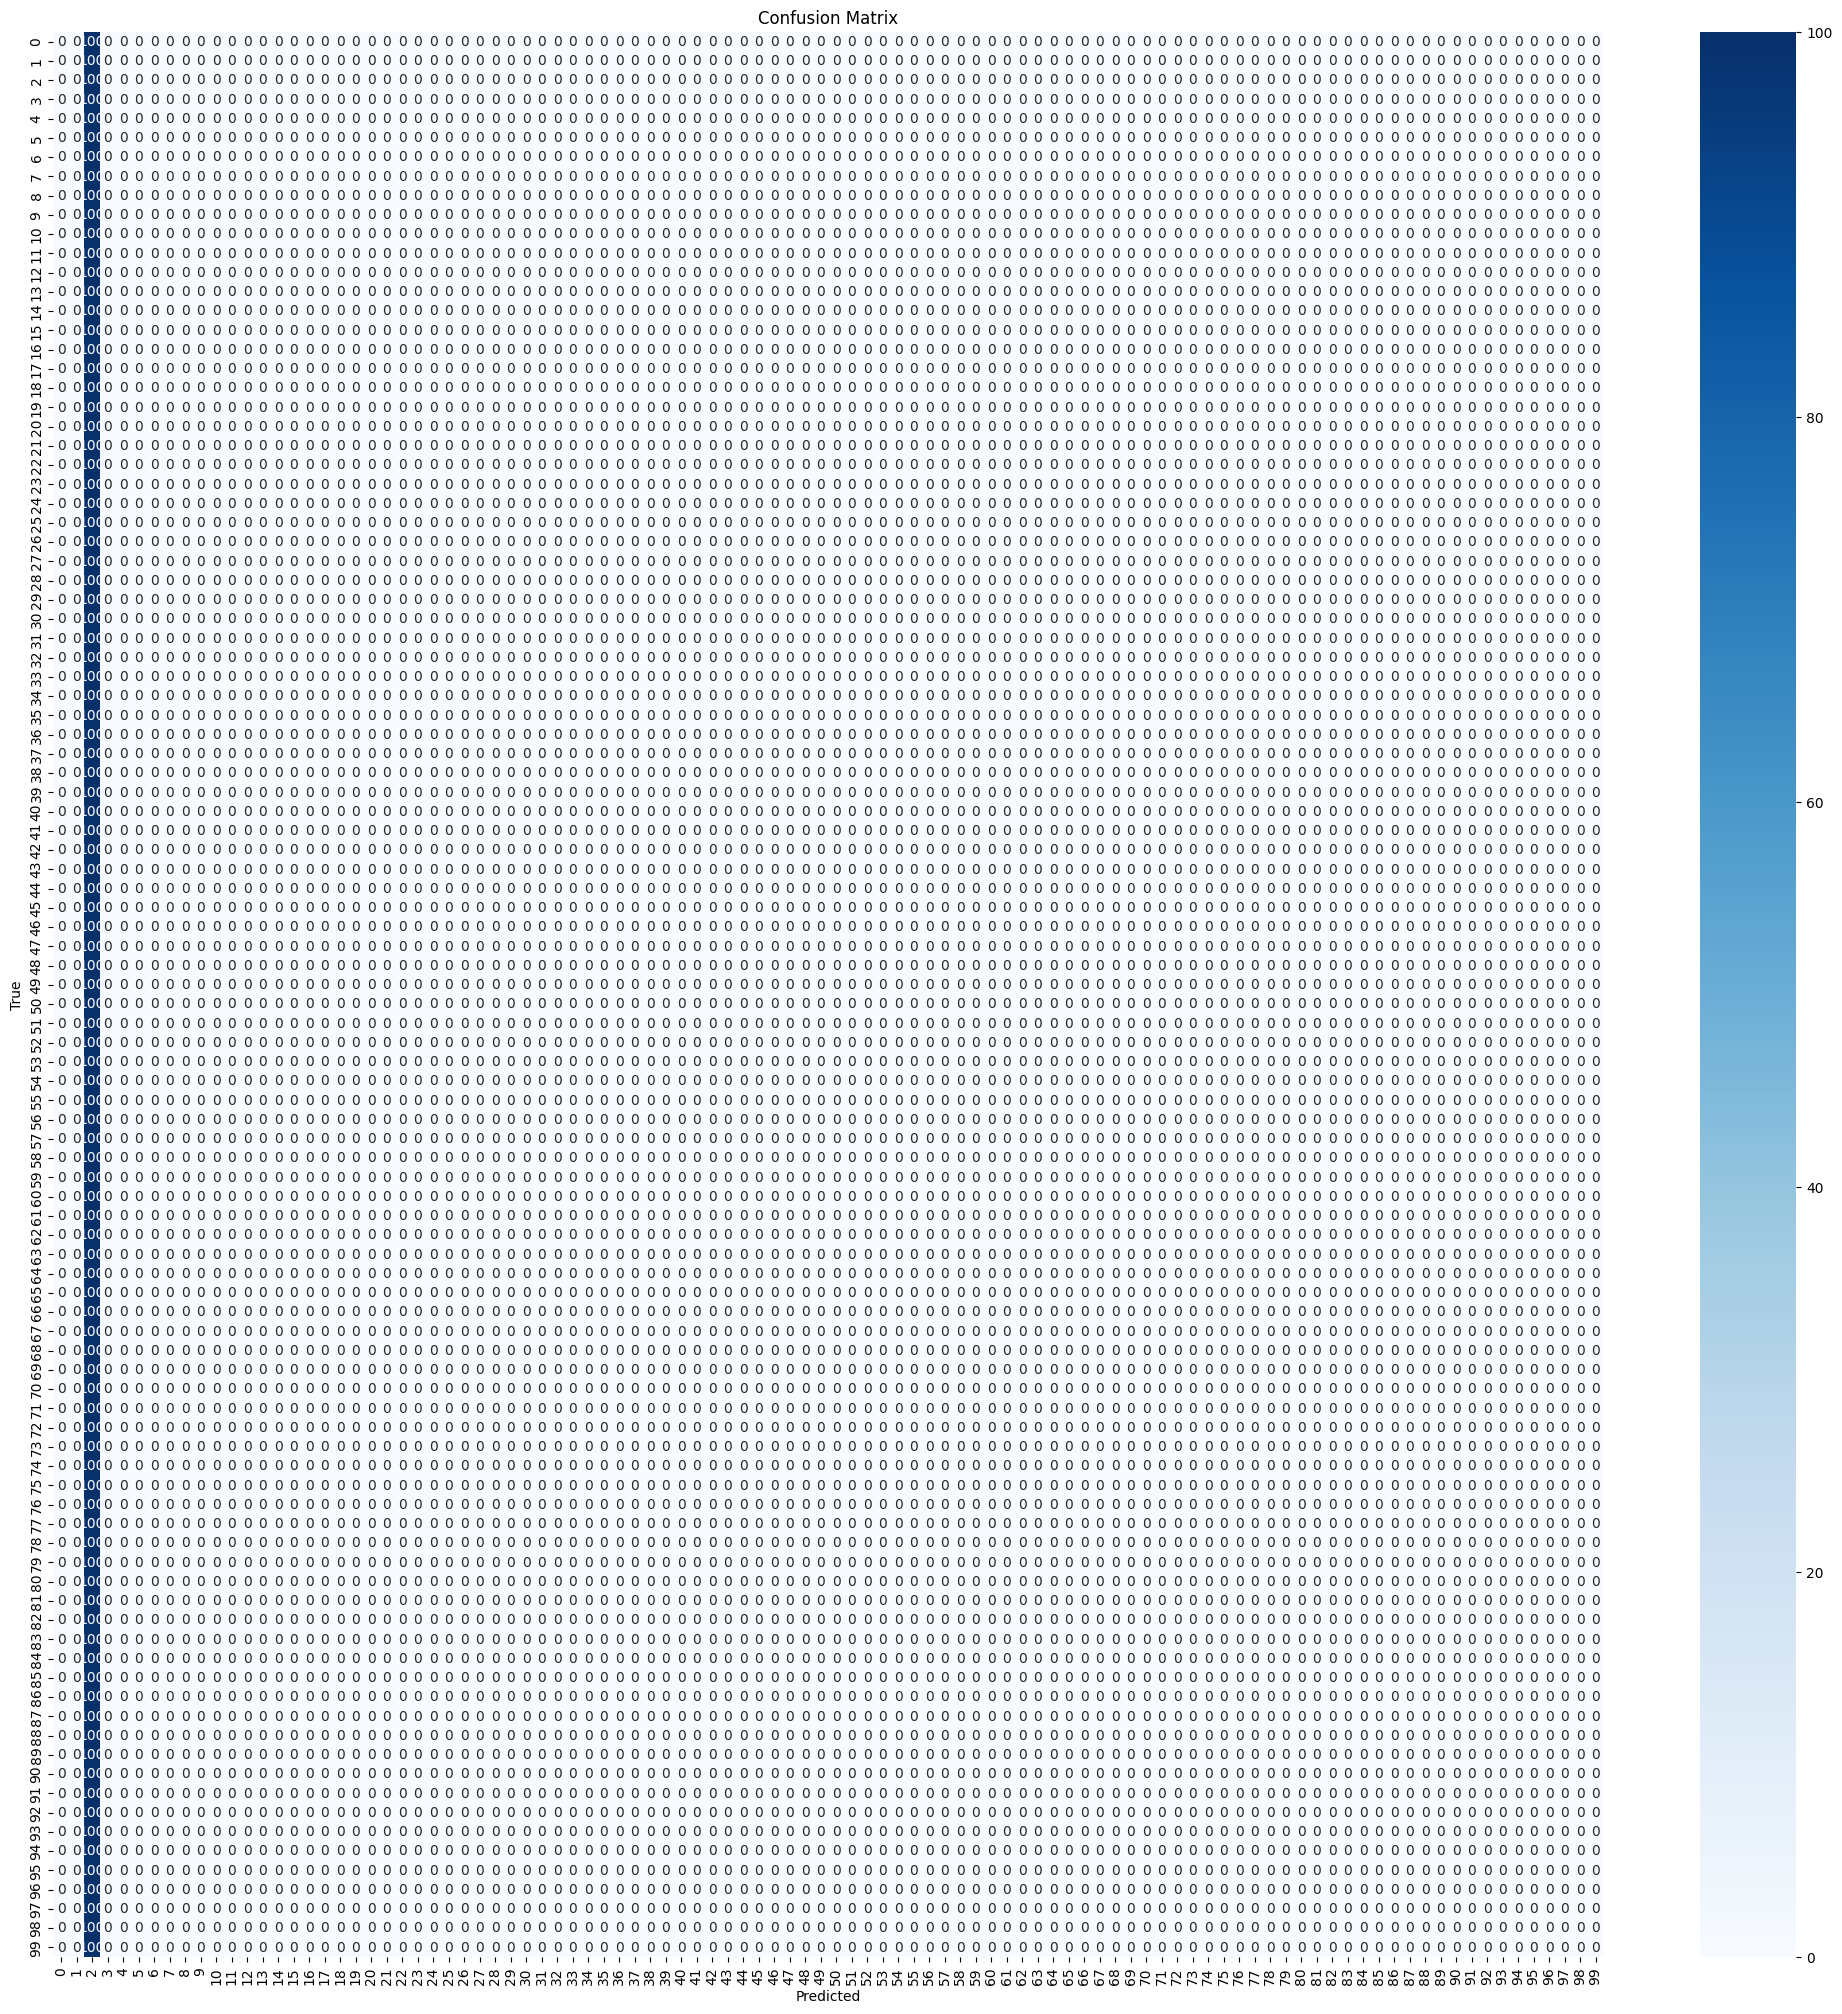

In [ ]:
## Importing libraries
from   keras.datasets import cifar100
import tensorflow as tf
import numpy  as np
import seaborn as sns
import matplotlib.pyplot  as plt
from   sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from   keras.applications import EfficientNetV2B0
from   keras.callbacks import ModelCheckpoint
from   keras.optimizers import Adam
from   keras.layers import Dense, GlobalAveragePooling2D
from   keras.losses import SparseCategoricalCrossentropy


# Load the CIFAR-100 dataset
# Fine label
(train_X, train_y), (test_X, test_y) = cifar100.load_data(label_mode='fine')

# coarse labels
(_, train_coarse_y), (_, test_coarse_y) = cifar100.load_data(label_mode='coarse')


## Dataset preprocessing
classes_num = 100

train_X = train_X.astype("float32")/ 255.0
test_X  = test_X.astype("float32") / 255.0

train_y = tf.keras.utils.to_categorical(train_y, classes_num)
test_y  = tf.keras.utils.to_categorical(test_y, classes_num)
train_coarse_y  = tf.keras.utils.to_categorical(train_coarse_y, classes_num)
test_coarse_y  = tf.keras.utils.to_categorical(test_coarse_y, classes_num)


## The CNN model
base = EfficientNetV2B0(
    weights='imagenet',
    input_shape=(32,32,3),
    include_top=False,
)

base.trainable = False

model = tf.keras.Sequential([
    base,   ## Base model
    GlobalAveragePooling2D(), ## 2D Pooling
    Dense(256, activation='relu'), ## Dense layer with relu activation
    Dense(classes_num, activation='softmax') ## Dense layer with softmax activation

])

## Training of the model
epoch = 10
batch_size = 64

# Fine labels
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy', metrics=['accuracy'])

best_model = ModelCheckpoint('model.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)
model.fit(
    train_X,
    train_y,
    batch_size=batch_size,
    epochs=epoch,
    validation_data=(test_X, test_y),
    callbacks=[best_model]
)

# Coarse label
model.load_weights('model.h5')
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


model.fit(
    train_X,
    train_coarse_y,
    batch_size=batch_size,
    epochs=epoch,
    validation_data=(test_X, test_coarse_y),
    callbacks=[best_model]
)



## Evaluation of the model
_, fine_accuracy = model.evaluate(test_X, test_y)
_, coarse_accuracy = model.evaluate(test_X, test_coarse_y)

print("Fine Label Accuracy:", fine_accuracy)
print("Coarse Label Accuracy:", coarse_accuracy)

## Predictions
p = model.predict(test_X)
p_labels = np.argmax(p, axis=1)
r_labels = np.argmax(test_y, axis=1)

# misclassified
misclassified = test_X[p_labels != r_labels]
mr_labels = r_labels[p_labels != r_labels]
mp_labels = p_labels[p_labels != r_labels]
plt.figure(figsize = (25,25))
for i in range(25):
    plt.subplot(5,5,i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(misclassified[i], cmap=plt.cm.binary)
    plt.xlabel(f"True {mr_labels[i]} misclassified {mp_labels[i]}")

plt.show()


# Confusion Matrix
cm = confusion_matrix(r_labels, p_labels)
c_labels = [str(i) for i in range(classes_num)]
plt.figure(figsize = (25,25))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=c_labels, yticklabels=c_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Question 2: Performance on 20-class subset of CIFAR-100
### Part 2A: Performance on "different" classes
Choose the 20 class subset such that there is one class from each of the 20 superclasses. Re-train a transfer learning model, similar to what you did in Part 1.

How much data do you need to achieve similar accuracy as you achieved in Part 1? (ie how many images from each class is needed?)

What is your accuracy, for coarse and fine labels for both training and testing, if you utilize all available training data (ie 500 images per class)?

Plot several misclassified images. Plot confusion matrices

In [ ]:


# Set the desired accuracy level from Part 1
desired_accuracy = 0.85

# Start with a small number of images per class
images_per_class = 100

# Define batch size and number of epochs
batch_size = 32
epochs = 20

# Define a function for learning rate scheduler
def lr_scheduler(epoch):
    if epoch < 10:
        return 0.001
    else:
        return 0.0001

# Create an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

while True:
    # Subset the CIFAR-100 dataset with the specified number of images per class
    subset_train_X = []
    subset_train_y = []

    for class_index in range(classes_num):
        class_images = train_X[train_y[:, class_index] == 1][:images_per_class]
        class_labels = train_y[train_y[:, class_index] == 1][:images_per_class]
        subset_train_X.extend(class_images)
        subset_train_y.extend(class_labels)

    subset_train_X = np.array(subset_train_X)
    subset_train_y = np.array(subset_train_y)

    # Preprocess the data
    subset_train_X = subset_train_X.astype("float32") / 255.0
    test_X = test_X.astype("float32") / 255.0

    # Build and train the transfer learning model
    base = EfficientNetV2B3(
        weights='imagenet',
        input_shape=(32, 32, 3),
        include_top=False,
    )

    base.trainable = False

    model = tf.keras.Sequential([
        base,
        BatchNormalization(),
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dense(classes_num, activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define the learning rate scheduler callback
    lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

    model.fit(
        subset_train_X,
        subset_train_y,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(test_X, test_y),
        callbacks=[early_stopping, lr_scheduler_callback]
    )

    # Evaluate the model's accuracy
    _, fine_accuracy = model.evaluate(test_X, test_y)
    _, coarse_accuracy = model.evaluate(test_X, test_coarse_y)

    print("Fine Label Accuracy:", fine_accuracy)
    print("Coarse Label Accuracy:", coarse_accuracy)

    # Check if the desired accuracy is achieved
    if fine_accuracy >= desired_accuracy and coarse_accuracy >= desired_accuracy:
        break

    # Increase the number of images per class
    images_per_class += 100

# Utilize all available training data (500 images per class)
all_train_X = train_X
all_train_y = train_y

# Build and train the transfer learning model with all available training data
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(
    all_train_X,
    all_train_y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(test_X, test_y),
    callbacks=[early_stopping, lr_scheduler_callback]
)

# Evaluate the model's accuracy on all available training data
_, fine_accuracy_all = model.evaluate(test_X, test_y)
_, coarse_accuracy_all = model.evaluate(test_X, test_coarse_y)

print("Fine Label Accuracy (All Training Data):", fine_accuracy_all)
print("Coarse Label Accuracy (All Training Data):", coarse_accuracy_all)

# Plot misclassified images
misclassified = test_X[p_labels != r_labels]
mr_labels = r_labels[p_labels != r_labels]
mp_labels = p_labels[p_labels != r_labels]
plt.figure(figsize=(25, 25))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(misclassified[i], cmap=plt.cm.binary)
    plt.xlabel(f"True {mr_labels[i]} misclassified {mp_labels[i]}")

plt.show()

# Confusion Matrix
cm = confusion_matrix(r_labels, p_labels)
c_labels = [str(i) for i in range(classes_num)]
plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=c_labels, yticklabels=c_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Epoch 1/20
313/313 [==============================] - 17s 23ms/step - loss: 4.8619 - accuracy: 0.0094 - val_loss: 4.6503 - val_accuracy: 0.0100 - lr: 0.0010
Epoch 2/20
313/313 [==============================] - 5s 17ms/step - loss: 4.7624 - accuracy: 0.0106 - val_loss: 4.6380 - val_accuracy: 0.0100 - lr: 0.0010
Epoch 3/20
313/313 [==============================] - 5s 17ms/step - loss: 4.7449 - accuracy: 0.0088 - val_loss: 4.6280 - val_accuracy: 0.0100 - lr: 0.0010
Epoch 4/20
313/313 [==============================] - 5s 17ms/step - loss: 4.7309 - accuracy: 0.0106 - val_loss: 4.6357 - val_accuracy: 0.0100 - lr: 0.0010
Epoch 5/20
313/313 [==============================] - 5s 17ms/step - loss: 4.7248 - accuracy: 0.0107 - val_loss: 4.6288 - val_accuracy: 0.0100 - lr: 0.0010
Epoch 6/20
313/313 [==============================] - 5s 17ms/step - loss: 4.7147 - accuracy: 0.0104 - val_loss: 4.6278 - val_accuracy: 0.0100 - lr: 0.0010
Epoch 7/20
313/313 [==============================] - 5s 17ms/s

KeyboardInterrupt: ignored

### Part 2B: Performance on "similar" classes
Choose your 20 classes such that they come from a minimum number of superclasses. Repeat your analysis from Part 2A:
1. Re-train a transfer learning model
2. Find how much data is needed to achieve similar accuracy as Part 1.
3. Find the maximum accuracy, utilizing all available training data.

Plot several misclassified images and confusion matrices for both coarse and fine labels.


Are your results different than they were for Part 2A?

## Question 3: Performance on 5-class subset of CIFAR-100
### Part 3A: Performance on "different" classes
Repeat your analysis from Part 2A, but for 5 classes chosen from 5 different superclasses.

Are your results different from Part 2A?

In [ ]:
# Set the desired accuracy level from Part 2A
desired_accuracy = 0.85

# Define the 5 classes chosen from different superclasses
selected_classes = [10, 25, 40, 55, 70]  # Modify the class indices as per your selection

# Subset the CIFAR-100 dataset with the selected classes
subset_train_X = []
subset_train_y = []
subset_test_X = []
subset_test_y = []

for class_index in selected_classes:
    class_train_images = train_X[train_y[:, class_index] == 1]
    class_train_labels = train_y[train_y[:, class_index] == 1]
    class_test_images = test_X[test_y[:, class_index] == 1]
    class_test_labels = test_y[test_y[:, class_index] == 1]

    subset_train_X.extend(class_train_images)
    subset_train_y.extend(class_train_labels)
    subset_test_X.extend(class_test_images)
    subset_test_y.extend(class_test_labels)

subset_train_X = np.array(subset_train_X)
subset_train_y = np.array(subset_train_y)
subset_test_X = np.array(subset_test_X)
subset_test_y = np.array(subset_test_y)

# Preprocess the data
subset_train_X = subset_train_X.astype("float32") / 255.0
subset_test_X = subset_test_X.astype("float32") / 255.0

# Build and train the transfer learning model
base = EfficientNetV2B3(
    weights="imagenet",
    input_shape=(32, 32, 3),
    include_top=False,
)

base.trainable = False

model = tf.keras.Sequential([
    base,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(len(selected_classes), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(
    subset_train_X,
    subset_train_y[:, selected_classes],
    batch_size=batch_size,
    epochs=epoch,
    validation_data=(subset_test_X, subset_test_y[:, selected_classes])
)

# Evaluate the model's accuracy
_, fine_accuracy = model.evaluate(subset_test_X, subset_test_y[:, selected_classes])
_, coarse_accuracy = model.evaluate(subset_test_X, subset_test_coarse_y[:, selected_classes])

print("Fine Label Accuracy (5-class subset):", fine_accuracy)
print("Coarse Label Accuracy (5-class subset):", coarse_accuracy)

# Plot misclassified images
subset_pred_labels = np.argmax(model.predict(subset_test_X), axis=1)
subset_true_labels = np.argmax(subset_test_y[:, selected_classes], axis=1)

misclassified = subset_test_X[subset_pred_labels != subset_true_labels]
mr_labels = subset_true_labels[subset_pred_labels != subset_true_labels]
mp_labels = subset_pred_labels[subset_pred_labels != subset_true_labels]

plt.figure(figsize=(25, 25))
for i in range(len(misclassified)):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(misclassified[i], cmap=plt.cm.binary)
    plt.xlabel(f"True {mr_labels[i]} misclassified {mp_labels[i]}")

plt.show()

# Confusion Matrix
cm = confusion_matrix(subset_true_labels, subset_pred_labels)
c_labels = [str(i) for i in range(len(selected_classes))]

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=c_labels, yticklabels=c_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### Part 3B: Performance on "similar" classes
Repeat your analysis from Part 3A, but for 5 classes chosen from the SAME superclass.

Are your results different from 3A and from 2B?

## Question 4: Performance on 2-class subset of CIFAR-100
### Part 4A: Performance on "different" classes
Create a binary classifier, choosing two classes from different superclasses.
Repeat analysis from Part 3A.

Are your results different than previous Parts?

### Part 4B: Performance on "similar" classes
Choose your two classes from the same superclass, and repeat analysis.

What are your results?

## Question 5: Summarize your findings
Are there any mathematical relationships between number of classes, accuracy, and number of images used in training data? Did it make a difference if the classes were different or similar? Provide any other analyses or interesting insights.